# KaaS Benchmarking Results
This notebook processes the results from all KaaS experiments used in the paper(s). Most of the heavy pre-processing and data ingest is handled in util.py while the notebook itself focuses on plotting and summarizing.

## Standards and Assumptions
- **Units:** All times are in ms. They are converted to other units only right before plotting/printing.
- **Metric Naming Conventions:** Metrics starting with 't_' are times, 'n_' are counts, and no prefix are something non-standard (these should be avoided)

In [1]:
import yaml
import pathlib
import pandas as pd
from pprint import pprint
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn
import brokenaxes


import util

In [2]:
# Color style similar to ppt color scheme
plt.style.use('seaborn-colorblind')
# plt.rc('axes', prop_cycle=(plt.cycler('linestyle', ['-', '--', ':', '-.'])))

#Latex Default Font
plt.rc('font', family='serif') 
plt.rc('font', serif='Latin Modern Roman')
matplotlib.rcParams.update({'font.size': 16})
plt.rcParams.update({'figure.autolayout': True})

def make_hatches(ax, df):
    hatches = [h*len(df.index) for h in [['//'], ['--'], ['x'], ['\\'], ['||'], ['+'], ['o'], ['.']]]
    hatches = sum(hatches, [])

    if len(hatches) < len(ax.patches):
        print("Not enough hatches defined")
        
    for i,bar in enumerate(ax.patches):
        bar.set_hatch(hatches[i])
    ax.legend()

# Constants 

In [3]:
baselineName = 'eTask'
kaasName = 'kTask'
resBaseDir = pathlib.Path("results/asplos")

modelRenames = {"complexCutlassGemm": "cGEMM"}
linestyles = [':', '--', '-.', (0, (3, 1, 1, 1, 1, 1)), '-']

# Latency/Throughput Graph

In [ ]:
AllLatThr = util.loadAllLatThr(resBaseDir / 'latThr')

In [ ]:
AllLatThr['resnet50'][8]['kaas']

In [ ]:
model = 'cGEMM'

fig, ax = plt.subplots()

r = AllLatThr[model][4]['kaas']
ax.plot(r['qps'], r['p50'], label='KaaS (n=4)')

r = AllLatThr[model][8]['kaas']
ax.plot(r['qps'], r['p50'], label='KaaS (n=8)')

r = AllLatThr[model][4]['fractional']
ax.plot(r['qps'], r['p50'], label='Part (n=4)')

r = AllLatThr[model][4]['fractional']
ax.plot(r['qps'], r['p50'], label='Part (n=8)')

r2 = AllLatThr[model][8]['kaas']

ax.set_ylabel('latency (ms)')
ax.set_xlabel('throughput (qps)')
ax.legend()

# Latency Distribution
### MlPerf
- **Ingested Data:**
    - latIndependent: full results from the independent submission rates mlperf experiments
    - latDependent: full results from the dependent (uses the lowest submission rate between modes) submission rates mlperf experiments
- **Loaded By:** util.loadAllMlPerf
    - 90, 50, etc. represent the metric being plotted (e.g., 50th and 90th percentiles)
- **Generated By**: ./multiExperiment.py -e lat
    - output dir has the form latSuite_datetimestuff/runX
    - Supports aggregating multiple runs. You can add the -o option to point to an existing output directory to add runs.

In [74]:
lat = util.loadAllMlPerf(resBaseDir / "lat")

In [75]:
def plotLatencies(lats, title="", log=True):
    cleanDfs = []
    for name, df in lats.items():
        cleanDfs.append(df.rename({baselineName: f"{name} {baselineName}", kaasName: f"{name} {kaasName}"}, axis=1))
    pltDf = pd.concat(cleanDfs, axis=1).fillna(0) / 1000
#     plot = pltDf.plot(kind='bar', width=0.7, figsize=(10,4))
#     plot = pltDf.plot(kind='bar', width=0.7, figsize=(10,3), logy=log)
#     plot = pltDf.plot(kind='line', linewidth=2)
    plot = seaborn.lineplot(data=pltDf, linewidth=3)

    plot.set_ylabel("90th Percentile Latency (s)")
    plot.set_xlabel("Number of Replicas")
    plot.tick_params(axis='x', labelrotation=0)
    make_hatches(plot, pltDf)
    
    plot.legend(bbox_to_anchor=(1,1))
    return plot

def plotNormalized(lats, log=False):
    plotDf = pd.DataFrame({workloadName: df.Actor / df.KaaS for workloadName, df in lats.items()})
#     plot = pltDf.plot(kind='bar', width=0.7, figsize=(10,4))
#     plot = plotDf.plot(kind='bar', width=0.7, figsize=(10,3), logy=log)
    plot = plotDf.plot(kind='line', linewidth=2, logy=log)
    plot.set_ylabel("90th Percentile Latency\n(ms)")
    plot.set_xlabel("Number of Replicas")
    plot.tick_params(axis='x', labelrotation=0)
    make_hatches(plot, plotDf)
    
def plotLatWithConfidence(p50s, p90s, title=None):
    p50s = (p50s / 1000).interpolate(method='linear', limit_area='inside')
    p90s = (p90s / 1000).interpolate(method='linear', limit_area='inside')
    
    p50s = p50s.rename({"exclusive": "eTask"}, axis='columns')
    p50s = p50s.rename({"kaas": "kTask"}, axis='columns')
    p90s = p90s.rename({"exclusive": "eTask"}, axis='columns')
    p90s = p90s.rename({"kaas": "kTask"}, axis='columns')
    ax = p50s.plot(kind='line', style=['g-', 'b--'], figsize=(5, 3))
    ax.fill_between(p50s.index, p50s[kaasName], p90s[kaasName], color='g', hatch="+", alpha=0.1)
    ax.fill_between(p50s.index, p50s[baselineName], p90s[baselineName], color='b', alpha=0.1)
    
#     ax.legend(loc='upper left')
    ax.legend()
    ax.set_ylabel("Latency (s)")
    ax.set_xlabel("Number of Replicas")
    if title is not None:
        ax.set_title(title)
        
    return ax

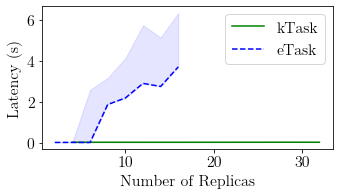

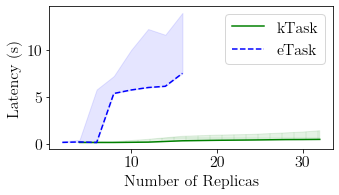

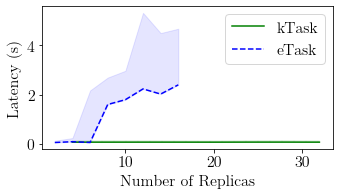

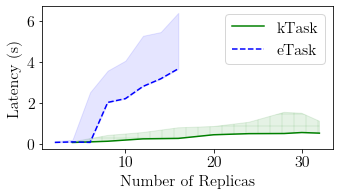

In [78]:
models = ['resnet50', 'bert', 'jacobi', 'cGEMM']
# models = ['cGEMM']
# bbox = matplotlib.transforms.Bbox.from_bounds(0, 0, 5, 4)
p90s = util.aggregateModels(lat, metric='p90')
p50s = util.aggregateModels(lat, metric='p50')
for model in models:
    ax = plotLatWithConfidence(p50s[model], p90s[model])
    ax.figure.savefig(f"figs/latDistResults_{model}.png", dpi=300, bbox_inches='tight')
#     ax.figure.savefig(f"figs/latDistResults_{model}.png", dpi=300)

In [ ]:
# subset = {k: v.loc[:4] for k, v in latResults90.items() if k in ['resnet50']}
# subset = {k: v for k, v in latResults.items() if k in ['resnet50', 'jacobi']}
# subset = {k: v for k, v in latResults.items() if k in ['resnet50']}
# subset = {k: v.loc[:4] for k, v in latResults.items()}
# subset = {k: v.loc[:,['KaaS']] for k, v in latResults.items()}
# plot = plotLatencies(latResults)
# plot = plotLatencies(subset)
# plot = plotLatencies({k: v for k, v in latResults.items() if k in ['resnet50', 'jacobi']}, log=True)
# plot.figure.savefig("figs/latDistResults.png", dpi=300, bbox_inches='tight')

# CDFs
Same dataset as lat distribution

In [54]:
def plotCDFs(configs, indData, depData, title=''):
    lats = {}
    for model, mode, nReplica, independent in configs:
        expName = f"{model}_{mode}_{nReplica}"
        
        if independent:
            dat = indData[expName]
        else:
            dat = depData[expName]
            
        # Convert any ugly internal names to prettier ones
        if model in modelRenames:
            model = modelRenames[model]
        
        if mode == 'exclusive':
            label = f"{baselineName} ({round(dat['submission_rate'], 1)}/s)"
        else:
            label = f"{kaasName} ({round(dat['submission_rate'], 1)}/s)"
            
        lats[label] = dat['latencies']

                
    fig, ax = plt.subplots(figsize=[4.5,3])
    n, bins, patches = ax.hist(list(lats.values()), bins='auto', label=list(lats.keys()), cumulative=True, density=True,
                               histtype='step', linewidth=2, linestyle='-')

    # Get rid of the zero value at the end (causes a vertical line)
    for idx, patch in enumerate(patches):
        patch[0].set_linestyle(linestyles[idx])
        patch[0].set_xy(patch[0].get_xy()[:-1])

    ax.set_xlabel("Latency (s)")
    ax.legend(loc='lower right') 
    ax.set_title(title)
    
    return ax  

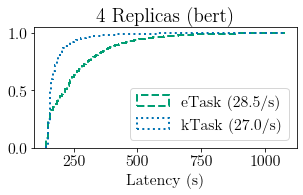

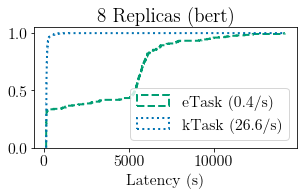

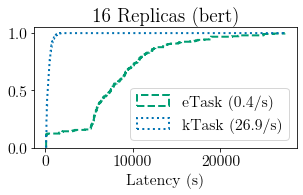

In [55]:
configs = [
    ("bert", 'kaas', 4, True),
    ('bert', 'exclusive', 4, True)
]
ax = plotCDFs(configs, lat, None, title="4 Replicas (bert)")
ax.figure.savefig("figs/cdfBert4.png", dpi=300, bbox_inches='tight')

configs = [
    ("bert", 'kaas', 8, True),
    ('bert', 'exclusive', 8, True)
]
ax = plotCDFs(configs, lat, None, title="8 Replicas (bert)")
ax.figure.savefig("figs/cdfBert8.png", dpi=300, bbox_inches='tight')

configs = [
    ("bert", 'kaas', 16, True),
    ('bert', 'exclusive', 16, True)
]
ax = plotCDFs(configs, lat, None, title="16 Replicas (bert)")
ax.figure.savefig("figs/cdfBert16.png", dpi=300, bbox_inches='tight')

# Throughput Experiments
- **Ingested Data:** thrResults
- **Loaded By:** util.loadAllThroughput
- **Generated By:** multiExperiment.py -t throughput
    - Manually configure the experiments to run there using the `configs = itertoosl.product(...)` call at the bottom of that file.

In [16]:
thrResults = util.loadAllThroughput(resBaseDir / "throughputFull")

In [17]:
def plotThroughput(dfs, title=""):
    cleanDfs = []
    for name, wlDf in dfs.items():
        wlDf = wlDf.drop('fractional', axis='columns')
        cleanDfs.append(wlDf.rename({'kaas': f"{name} ({kaasName})", 'exclusive': f"{name} ({baselineName})"}, axis=1))
    pltDf = pd.concat(cleanDfs)
#     fig, ax = plt.subplots(figsize=(7,3))
    fig, ax = plt.subplots()
#     with seaborn.plotting_context("notebook", font_scale=1.5):
    plot = seaborn.lineplot(data=pltDf, linewidth=3, ax=ax)
    plot.set_ylabel("Aggregate QPS")
    plot.set_xlabel("Number of Replicas")
    plot.tick_params(axis='x', labelrotation=0)
    plot.legend(loc='center', bbox_to_anchor=(0.5,1.2), ncol=2)
#         plot.legend()
    return plot

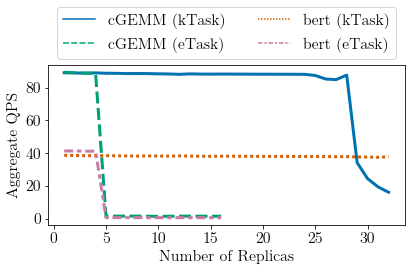

In [20]:
plotBig = plotThroughput({ k: v for k, v in thrResults.items() if k in ['cGEMM', 'bert']})
plotBig.figure.savefig("figs/throughputHighMem.png", dpi=300, bbox_inches='tight')

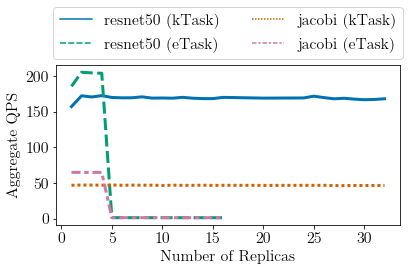

In [21]:
plotSmall = plotThroughput({ k: v for k, v in thrResults.items() if k in ['resnet50', 'jacobi']})
plotSmall.figure.savefig("figs/throughputLowMem.png", dpi=300, bbox_inches='tight')

# Microbench
- **Ingested Data:** microMeans, microStds
- **Loaded By:** util.loadMicroSuite()
- **Generated By:** ./micro.py

In [ ]:
microMeans, microStds = util.loadMicroSuite(resBaseDir / 'micro_160622-215600/')

In [ ]:
def getLimits(pltDF):
    totalHeights = pltDf.transpose().sum()
    maxHeight = totalHeights.max()

    threshold = 0.25
    bigHeights = totalHeights[totalHeights > maxHeight * threshold]
    minBig = bigHeights.min()
    
    smallHeights = totalHeights[totalHeights < maxHeight * threshold]
    maxSmall = smallHeights.max()

    return ((0, maxSmall * 1.2), (minBig * 0.7, maxHeight * 1.2))
    
    
def plotMicroBroken(pltDF, title=''):
    limits = getLimits(pltDF)
    
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios" : [0.5, 1]})
    
    ax1.spines['bottom'].set_visible(False)
    ax1.tick_params(axis='x',which='both',bottom=False)
    ax2.spines['top'].set_visible(False)
    
    ax2.set_ylim(limits[0][0], limits[0][1])
    ax1.set_ylim(limits[1][0], limits[1][1])
    
    pltDF.plot(kind='bar', stacked=True, ax=ax1, legend=None)
    pltDF.plot(kind='bar', stacked=True, ax=ax2, legend=None)
    
    make_hatches(ax1, pltDF)
    make_hatches(ax2, pltDF)
    
    # sets the slash on the break on the axis
    for tick in ax2.get_xticklabels():
        tick.set_rotation(0)
    d = .015  
    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((-d, +d), (-d, +d), **kwargs)      
    ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
    kwargs.update(transform=ax2.transAxes)  
    ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  
    ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
    
    ax1.set_title(title)
    
    ax1.set_xlabel("")
    ax2.set_xlabel("")
    ax1.tick_params(axis='x', rotation=0)
    ax2.tick_params(axis='x', rotation=0)
    
    ax2.set_ylabel("Time (ms)")
    ax2.yaxis.set_label_coords(-0.1, 0.85)
    
    ax2.get_legend().remove()
    ax1.legend(bbox_to_anchor=[1, 0.5])
    # Skinny legend
#     ax1.legend(loc='center left', bbox_to_anchor=[1,0.5])
    # Regular readable legend off to the side
#     ax1.legend(loc='center left', bbox_to_anchor=[1,-1])
    
    return fig

def cleanForPlot(rawDf):
    pltDf = rawDf.transpose().drop(columns=['t_e2e'])
    pltDf = pltDf.rename(columns={"t_kernel": "Kernel Run", 't_cudaMM': "GPU Malloc", 't_kernel_init': 'Kernel Init',
                                 "t_cuda_copy": "GPU Copy", "t_data_layer": "Data Layer", "t_other": "Overheads"})
    pltDf = pltDf.rename(index={"kaasWarm": f"{kaasName}\n(warm)", "kaasCold": f"{kaasName}\n(cold)",
                                "actCold": f"{baselineName}\n(cold)", "actWarm": f"{baselineName}\n(warm)"})
#     print(pltDf.index)
#     return pltDf.rename(index={'kaasWarm': "KaaS (warm)"}, errors='ignore')
    return pltDf

def plotLegend(pltDf):
    plot = pltDf.plot(kind='bar', stacked=True)
    make_hatches(plot, pltDf)
    
    label_params = plot.get_legend_handles_labels()
    figl, axl = plt.subplots()
    axl.axis(False)
    axl.legend(*label_params, loc="center", ncol=1, bbox_to_anchor=(0.5, 0.5), prop={"size":50})
    return figl 

def plotMicro(pltDf):
    plot = pltDf.plot(kind='bar', stacked=True, figsize=(3.5,3.5), width=0.8)
    plot.tick_params(axis='x', rotation=0)
#     plot = pltDf.plot(kind='barh', stacked=True)
    make_hatches(plot, pltDf)
    plot.legend().remove()
#     plot.legend(loc='upper left', bbox_to_anchor=[1,1])
#     plot.legend(ncol=6, loc='lower left', bbox_to_anchor=[-0.25,1])
#     plot.set_ylabel("Time (ms)")
    return plot

In [ ]:
# pltDf = microMeans.transpose().drop(columns=['t_e2e'])
pltDf = cleanForPlot(microMeans)

# plot = plotMicro(pltDf.loc[['KaaS (warm)', 'Actor (warm)']])
# plot = plotMicro(pltDf.loc[['KaaS (warm)', 'FaaS+GPU (warm)']])
# plot = plotMicro(pltDf.loc[['KaaS (cold)', 'FaaS+GPU (cold)']])
# plot = plotMicro(pltDf.loc[['KaaS (warm)', 'KaaS (cold)']])

# legendPlot = plotLegend(pltDf.loc[[f'{kaasName}\n(cold)']])
# legendPlot.savefig("figs/microLegend.png", dpi=300, bbox_inches='tight')

plot = plotMicro(pltDf.loc[[f'{kaasName}\n(cold)', f'{baselineName}\n(cold)']])
plot.figure.savefig("figs/microCold.png", dpi=300, bbox_inches='tight')

# plot = plotMicro(pltDf.loc[[f'{kaasName}\n(warm)', f'{baselineName}\n(warm)']])
# plot.figure.savefig("figs/microWarm.png", dpi=300, bbox_inches='tight')

# plot = plotMicro(pltDf.loc[[f'{kaasName}\n(warm)', f'{kaasName}\n(cold)']])
# plot.figure.savefig("figs/microKaasOnly.png", dpi=300, bbox_inches='tight')

# Online Experiment
Not used in the paper so far. Kept here in case it's useful in the future

In [ ]:
def plotOnline(lats, title=""):
    cleanDfs = []
    for name, df in lats.items():
        cleanDfs.append(df.rename({baselineName: f"{name}({baselineName})", kaasName: f"{name}({kaasName})"}, axis=1))
    pltDf = pd.concat(cleanDfs, axis=1).fillna(0)
    plot = pltDf.plot(kind='bar', width=0.7, figsize=(10,3))
    #plot = pltDf.plot(kind='line', linewidth=2)
    plot.set_ylabel("Aggregate QPS")
    plot.set_xlabel("Number of Replicas")
    plot.tick_params(axis='x', labelrotation=0)
    make_hatches(plot, pltDf)
    
    plot.legend(bbox_to_anchor=(1,1))
    return plot

In [ ]:
# plot = plotOnline(sloResults)
# plot.figure.savefig("figs/onlineResults.png", dpi=300, bbox_inches='tight')